# Neural Network

## 3.1 Dataloader
### What is Dataloader
Dataloader is a class that helps with shuffling and organizing the data in minibatches. We can import this class from `torch.utils.data`.

The job of a data loader is to sample minibatches from a dataset, giving us the flexibility to choose the size of our minibatch to be use for training in each iteration. The constructor takes a `Dataset` object as input, along with `batch_size` and a `shuffle` boolean variable that indicates whether the data needs to be shuffled at the beginning of each epoch.

In this chapter, we are going to do classification task based on Fashion MNIST dataset. Fashion MNIST dataset could be directly imported and downloaded from `torchvision.datasets.FashionMNIST`. Pytorch has collected several datasets (CIFAR, COCO, Cityscapes, etc..) in the `torchvision` library, you may have a look of the full list of datasets at [here](https://pytorch.org/docs/stable/torchvision/datasets.html).

In [1]:
# importing the required library
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Loading/Downloading the FashionMNIST dataset, download might takes some time 
train_set = torchvision.datasets.FashionMNIST(
    root = '../data',
    train = True,
    download = True,
    transform = transforms.ToTensor()
    )
test_set = torchvision.datasets.FashionMNIST(
    root = '../data',
    train = False,
    download = True,
    transform = transforms.ToTensor()
    )

Loading the dataset into the `DataLoader` and input your desired batch size for training

In [3]:
train_loader = DataLoader(train_set, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_set, batch_size = 32, shuffle = False)

In [4]:
# A view of the DataLoader

batch = next(iter(train_loader))
images, labels = batch

# Output the size of each batch
print(images.shape, labels.shape)

torch.Size([32, 1, 28, 28]) torch.Size([32])


Each images are assigned to one of the following labels:

- 0 T-shirt/top
- 1 Trouser
- 2 Pullover
- 3 Dress
- 4 Coat
- 5 Sandal
- 6 Shirt
- 7 Sneaker
- 8 Bag
- 9 Ankle boot

Let us plot the image out to have a look on how does the dataset looks like.

In [5]:
# Converting numeric labels to text label

def labelsText(labels):
    labelDict = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    label = (labels.item() if type(labels) == torch.Tensor else labels)
    return labelDict[label]

Labels: 
Sandal, Shirt, Coat, Pullover, Shirt, Shirt, Dress, Trouser, Bag, T-shirt/Top, 

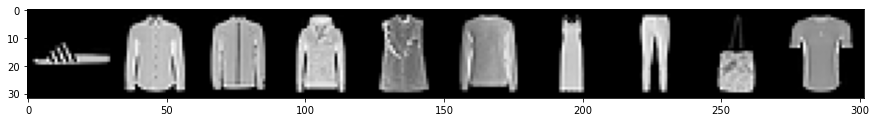

In [6]:
# Plotting out the images in the dataset

grid = torchvision.utils.make_grid(images[0:10], nrow = 10)

plt.figure(figsize = (15, 15))
plt.imshow(np.transpose(grid, (1, 2, 0)))

print("Labels: ")
for i in labels[0:10]:
    print(labelsText(i) + ", ", end = "")

## 3.2 Build your first Neural Network (Subclassing nn.Module)

### 3.2.1 Model Training
We had loaded our dataset into training and testing set, now let us build a simple Feedfoward Neural Network to perform classification on this dataset.

PyTorch has a whole submodule dedicated to neural networks, called `torch.nn`. It contains the building blocks needed to create all sorts of neural network architectures.

To build a Neural Network, it could be done in two ways :
- Calling the `nn.Sequential()` for fast implementation of the network
- Subclassing `nn.Module` to have more flexibility on designing the network, eg: writing the your own `foward()` method


Now let us start building the Neural Network

In [7]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

We would like to build a 4 layers neural network with ReLU activation function. Apply dropout with 20% probability to reduce the effect of overfitting. Let us try build our model using `nn.Sequential`.

In [8]:
# nn.Sequential()
torch.manual_seed(0)
model_sequential = nn.Sequential(nn.Linear(784,256),
                                 nn.Dropout(0.2),
                                 nn.ReLU(),
                                 nn.Linear(256,128),
                                 nn.Dropout(0.2),
                                 nn.ReLU(),
                                 nn.Linear(128,64),
                                 nn.Dropout(0.2),
                                 nn.ReLU(),
                                 nn.Linear(64,10),
                                )

We will build a wrapper function for our training called `training`. This wrapper function will take on parameters:
- n_epochs
- optimizer
- model
- loss_fn
- train_loader
- writer (Instance of Summary Writer to use TensorBoard for visualization)

Pytorch does support TensorBoard which provides the visualization and tooling needed for machine learning experimentation. It is a useful tool that we can use during our training. Now let's define our training loop and implement some of the TensorBoard methods. 

If you wish to know more on TensorBoard, you can access it at [here](https://pytorch.org/docs/stable/tensorboard.html)

In [9]:
from torch.utils.tensorboard import SummaryWriter

def training(n_epochs, optimizer, model, loss_fn, train_loader, writer):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        total = 0
        correct = 0
        for imgs, labels in train_loader:
            # Clearing gradient from previous mini-batch gradient computation  
            optimizer.zero_grad()
            
            # Reshape the tensor so that it fits the dimension of our input layer
            # Get predictions output from the model
            outputs = model(imgs.view(-1, 784))
            
            # Calculate the loss for curernt batch
            loss = loss_fn(outputs, labels)
            
            # Calculating the gradient
            loss.backward()
            
            # Updating the weights and biases using optimizer.step
            optimizer.step()
            
            # Summing up the loss over each epoch
            loss_train += loss.item()
            
            # Calculating the accuracy
            predictions = torch.max(outputs, 1)[1]
            correct += (predictions == labels).sum().item()
            total += len(labels)

        accuracy = correct * 100 / total
        writer.add_scalar('Loss ', loss_train / len(train_loader), epoch)
        writer.add_scalar('Accuracy ', accuracy, epoch)
        print('Epoch {}, Training loss {} , Accuracy {:.2f} %'.format(epoch, loss_train / len(train_loader), accuracy))
    writer.close()

We can open our TensorBoard in the terminal with the command of `tensorboard --logdir=runs`. Do remember change to the same directory as this notebook.

Now we are ready for training. Let's use `SGD` as our optimizer and `CrossEntropy` as loss function. 

In [10]:
torch.manual_seed(0)
model_SGD = model_sequential 
optimizer = optim.SGD(model_SGD.parameters(), lr = 1e-3) 
loss_fn = nn.CrossEntropyLoss()
writer = SummaryWriter(comment = 'SGD')
training(
    n_epochs = 10,
    optimizer = optimizer,
    model = model_SGD,
    loss_fn = loss_fn,
    train_loader = train_loader,
    writer = writer
)

Epoch 1, Training loss 2.2894855969746906 , Accuracy 18.28 %
Epoch 2, Training loss 2.2401039816538493 , Accuracy 28.62 %
Epoch 3, Training loss 2.0709991912841796 , Accuracy 29.36 %
Epoch 4, Training loss 1.6963001889546712 , Accuracy 35.94 %
Epoch 5, Training loss 1.406517707824707 , Accuracy 46.59 %
Epoch 6, Training loss 1.2153509410858154 , Accuracy 52.72 %
Epoch 7, Training loss 1.103756807899475 , Accuracy 56.64 %
Epoch 8, Training loss 1.0318541956583658 , Accuracy 59.33 %
Epoch 9, Training loss 0.9726073985735575 , Accuracy 62.38 %
Epoch 10, Training loss 0.931044387404124 , Accuracy 64.05 %


Let us build another model which we set log softmax as the activation function at the output layer and uses Negative log-likelihood loss function. Compare the results for both of these setting. This time we are going to build by subclassing `nn.Module`.

In [11]:
# Subclassing nn.Module
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_1 = nn.Linear(784, 256)
        self.act_1 = nn.ReLU()
        self.fc_2 = nn.Linear(256, 128)
        self.act_2 = nn.ReLU()
        self.fc_3 = nn.Linear(128, 64)
        self.act_3 = nn.ReLU()
        self.fc_4 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        out = self.dropout(self.act_1(self.fc_1(x)))
        out = self.dropout(self.act_2(self.fc_2(out)))
        out = self.dropout(self.act_3(self.fc_3(out)))
        # adding in softmax
        out = F.log_softmax(self.fc_4(out), dim = 1)
        return out
    
# Or you can use the Pytorch provided functional API when defining the forward method. Both of these are the same.

class Classifier_F(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_1 = nn.Linear(784, 256)
        self.fc_2 = nn.Linear(256, 128)
        self.fc_3 = nn.Linear(128, 64)
        self.fc_4 = nn.Linear(64, 10)
        
    def forward(self, x):
        out = F.dropout(F.relu(self.fc_1(x)), p = 0.2)
        out = F.dropout(F.relu(self.fc_2(out)), p = 0.2)
        out = F.dropout(F.relu(self.fc_3(out)), p = 0.2)
        out = F.log_softmax(self.fc_4(out), dim = 1)
        return out

In [12]:
torch.manual_seed(0)
model_SGD = Classifier() 
optimizer = optim.SGD(model_SGD.parameters(), lr = 1e-3) 
loss_fn = nn.NLLLoss()
writer = SummaryWriter(comment = 'SGD')
training(
    n_epochs = 10,
    optimizer = optimizer,
    model = model_SGD,
    loss_fn = loss_fn,
    train_loader = train_loader,
    writer = writer
)

Epoch 1, Training loss 2.2894890218098958 , Accuracy 18.39 %
Epoch 2, Training loss 2.2399076170603434 , Accuracy 28.73 %
Epoch 3, Training loss 2.068951116498311 , Accuracy 29.45 %
Epoch 4, Training loss 1.695164651552836 , Accuracy 36.16 %
Epoch 5, Training loss 1.4096814838409424 , Accuracy 46.69 %
Epoch 6, Training loss 1.2168791191418966 , Accuracy 52.60 %
Epoch 7, Training loss 1.1041425074577331 , Accuracy 56.25 %
Epoch 8, Training loss 1.0339518047332763 , Accuracy 59.37 %
Epoch 9, Training loss 0.9758181870142619 , Accuracy 62.02 %
Epoch 10, Training loss 0.9312916868527731 , Accuracy 63.92 %


CrossEntropy is actually performing log softmax and negative log likelihood at the same time. Therefore during the construction of our model we could neglect the declaration of activation function at the output layer and save some memory during the backpropagation.

Let us try using other optimizer `Adam` to do our training. Optimizer is one of the hyperparameters that we can tune on.

In [13]:
model_Adam = Classifier() 
optimizer = optim.Adam(model_Adam.parameters(), lr = 1e-3) 
loss_fn = nn.CrossEntropyLoss()
writer = SummaryWriter(comment = 'Adam')
training(
    n_epochs = 10,
    optimizer = optimizer,
    model = model_Adam,
    loss_fn = loss_fn,
    train_loader = train_loader,
    writer = writer
)

Epoch 1, Training loss 0.5945944479823112 , Accuracy 78.32 %
Epoch 2, Training loss 0.423241344755888 , Accuracy 84.78 %
Epoch 3, Training loss 0.38519719421068827 , Accuracy 86.15 %
Epoch 4, Training loss 0.36408053546349206 , Accuracy 86.94 %
Epoch 5, Training loss 0.35000673046310743 , Accuracy 87.39 %
Epoch 6, Training loss 0.3385574172397455 , Accuracy 87.74 %
Epoch 7, Training loss 0.32801985016465185 , Accuracy 88.09 %
Epoch 8, Training loss 0.3184917394856612 , Accuracy 88.41 %
Epoch 9, Training loss 0.31102090905706087 , Accuracy 88.59 %
Epoch 10, Training loss 0.3041634604026874 , Accuracy 88.89 %


In this case, we can see that `Adam` is performing better than the `SGD` with the same setting. Hyperparameter tuning is very important in order to obtain desired result

### 3.2.2 Model Saving
After training the model, we would like to save it for future usages. There are some pretty useful functions you might need to familar with:

- `torch.save`: It serialize the object to save to your machine. Models, tensors, and dictionaries of all kinds of objects can be saved using this function.
- `torch.load`: This function uses pickle’s unpickling facilities to deserialize pickled object files to memory.
- `torch.nn.Module.load_state_dict`: Loads a model’s parameter dictionary using a deserialized state_dict.

If you wish to know more on model saving, you can access it at [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

#### Saving only the weights

In [14]:
import os
if not os.path.exists('../generated_model'):
    os.mkdir('../generated_model')

In [15]:
# Saving the weights only of the model
torch.save(model_Adam.state_dict(),  '../generated_model/mnist_state_dict.pt')

In [16]:
# To load the state_dict, you must have an instance of the model
modelLoad = Classifier()
modelLoad.load_state_dict(torch.load('../generated_model/mnist_state_dict.pt'))

<All keys matched successfully>

#### Saving the entire model

In [17]:
# Saving the entire model
torch.save(model_Adam, '../generated_model/mnist_model.pt')

In [18]:
# Loading model
modelLoad = torch.load('../generated_model/mnist_model.pt')

### Add-ons: Saving Model in ONNX format
Pytorch also support saving model as ONNX (Open Neural Network Exchange) file type, which is a open format built to represent machine learning models. Let's see how to do it.

In [19]:
import torch.onnx 
dummy_input = torch.randn(32, 784, requires_grad = True)
torch.onnx.export(model_Adam, dummy_input, '../generated_model/model.onnx', verbose = True, input_names = ['input'], output_names = ['output'])

graph(%input : Float(32:784, 784:1),
      %fc_1.weight : Float(256:784, 784:1),
      %fc_1.bias : Float(256:1),
      %fc_2.weight : Float(128:256, 256:1),
      %fc_2.bias : Float(128:1),
      %fc_3.weight : Float(64:128, 128:1),
      %fc_3.bias : Float(64:1),
      %fc_4.weight : Float(10:64, 64:1),
      %fc_4.bias : Float(10:1)):
  %9 : Float(32:256, 256:1) = onnx::Gemm[alpha=1., beta=1., transB=1](%input, %fc_1.weight, %fc_1.bias) # C:\Users\GuanSheng.Wong\anaconda3\envs\Intro_to_Pytorch\lib\site-packages\torch\nn\functional.py:1674:0
  %10 : Float(32:256, 256:1) = onnx::Relu(%9) # C:\Users\GuanSheng.Wong\anaconda3\envs\Intro_to_Pytorch\lib\site-packages\torch\nn\functional.py:973:0
  %11 : Float(32:128, 128:1) = onnx::Gemm[alpha=1., beta=1., transB=1](%10, %fc_2.weight, %fc_2.bias) # C:\Users\GuanSheng.Wong\anaconda3\envs\Intro_to_Pytorch\lib\site-packages\torch\nn\functional.py:1674:0
  %12 : Float(32:128, 128:1) = onnx::Relu(%11) # C:\Users\GuanSheng.Wong\anaconda3\envs\Int

In [20]:
import onnx
#loading the onnx format model
model = onnx.load('../generated_model/model.onnx')

### 3.2.3 Inference
Sometimes, we would like to inference on the trained model to evaluate the performance. `model.eval()` will set the model to evaluation(inference) mode to set dropout, batch normalization layers, etc.. to evaluation mode. Evaluation mode will disable the usage of dropout and batch normalization during the `foward` method as it is not required during the inference.

In [21]:
# Using previous loaded model
modelLoad.eval()           

Classifier(
  (fc_1): Linear(in_features=784, out_features=256, bias=True)
  (act_1): ReLU()
  (fc_2): Linear(in_features=256, out_features=128, bias=True)
  (act_2): ReLU()
  (fc_3): Linear(in_features=128, out_features=64, bias=True)
  (act_3): ReLU()
  (fc_4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

After setting it to inference mode, we could pass in test data with the setting of 
```python 
with torch.no_grad():
``` 
as we do not have to calculate the gradient during the inference, this can help us save some memory.

In [22]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = modelLoad(images.view(-1, 784))
        predictions = torch.max(outputs, 1)[1]
        correct += (predictions == labels).sum()
        total += len(labels)
    accuracy_test = correct.item() * 100 / total
print("Test Accuracy : {:.2f} %".format(accuracy_test))

Test Accuracy : 88.09 %


## 3.3 Build your first Neural Network (Sequential Model)
### 3.3.1 Model Training

Altough there are many other machine learning techniques to tackle multi-variate linear regression, it would be interesting for us to tackle it using deep learning for learning purposes.
<br>In this sub-section, we will try to perform said regression using PyTorch `SequentialModel` 

We will use the Real Estate dataset from the `realEstate.csv` for our linear regression example. 

Description of data:
- House Age
- Distance from the unit to MRT station
- The number of Convenience Stores around the unit
- House Unit Price per 1000 USD

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

First we use pandas to load in the csv.<br>
Note that in this dataset there are a total of $3$ features and $1$ label.<br>
Thus from the data we will use `.iloc[]` to distinguish the features and labels.

In [24]:
data = pd.read_csv("../data/Regression/realEstate.csv", header = 0)
n_features = 3
X = data.iloc[:, 0:3].values
y = data.iloc[:, 3].values

Following that, we split our dataset into 70/30 train/test ratio.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, shuffle = True, random_state = 1022)

Next, we perform feature scaling onto `X_train` and `X_test` using `StandardScaler` from `scikit-learn`.<br>
*Note: only fit the train_set but transform both train and test sets*

In [26]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In section 3.1, we've touch on how Dataloaders are initialized and used in model training. It was simple, which is to pass in whatever `Dataset` we need into the Dataloader initializer. <br>

Here, we are using a custom dataset from a csv file as compared to the previous one which was prepared readily from torchvision. Thus in this case, we will have to build our own by subclassing from `torch.utils.data.Dataset`.

Whilst subclassing `Dataset`, PyTorch [documentation](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) notes that we have to override the `__getitem__()` method and optionally the `__len__()` method.<br>
We will mainly have three methods in this `Dataset` class:
- `__init__(self, data, label)`: helps us pass in the feature and labels into the dataset
- `__len__(self)`:allows the dataset to know how many instances of data there is 
- `__getitem__(self, idx)`:allows the dataset to get items from the data and labels by indexing

In [27]:
class Custom_Dataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype = torch.float32)
        self.labels = torch.tensor(labels, dtype  = torch.float32)

    def __len__(self):
        return self.features.shape[0]
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

After feature scaling, we initialize our custom datasets and put them into `Dataloader` constructor and our data is prepared. The next step will be modeling.

In [28]:
train_dataset = Custom_Dataset(X_train, y_train)
test_dataset = Custom_Dataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size = 32)
test_loader = DataLoader(test_dataset, batch_size = 128 )

Like we previously stated, there are two approaches of modeling.
- Subclassing `nn.Module` 
- Calling the `nn.Sequential()` 

`torch.nn.Sequential` is a simple function that accepts a list of `nn.Modules` and returns a model with all the sequential layers. We will be implementing these few layers:
1. nn.Linear(3,50)
2. nn.ReLU()
3. nn.Linear(50,25)
4. nn.ReLU()
5. nn.Linear(25,10)
6. nn.ReLU()
7. nn.Linear(10,1)

In [29]:
torch.manual_seed(123)
model_sequential = nn.Sequential(nn.Linear(n_features, 50),
                                 nn.ReLU(),
                                 nn.Linear(50, 25),
                                 nn.ReLU(),
                                 nn.Linear(25, 10),
                                 nn.ReLU(),
                                 nn.Linear(10, 1)
                                 )

For this regression probelm, the loss/criterion we will use is Mean-Squared-Error loss, which in PyTorch is `nn.MSELoss()`<br>
We will also choose to use `Adam` as our optimizer.<br> Remember, `torch.optim.*any_optimizer*` accepts `model.parameters()` to keep track of the model's parameters, hence we should always initialize our model first before our optimizer.

In [30]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_sequential.parameters(), lr = 0.01)

Now that our modeling is done, let's commence our training with using the training loop that defined previously

We will build a wrapper function for our training called `train_model`. This wrapper function will take on parameters:
- model
- loader
- loss_function/criterion
- optimizer
- number_of_epochs (optional)
- iteration_check (optional): *if False is passed in, losses of each iteration per epoch will not be printed>*

Below will be an overall workings an explaination of our train_model function:
1. In each epoch, each minibatch starts with `optimizer.zero_grad()`. This is to clear previously computed gradients from previous minibatches.
2. We get the features and labels by indexing our minibatch.
3. Compute forward propagation by calling `model(features)` and assigning it to a variable `prediction`
4. Compute the loss by calling `criterion(prediction, torch.unsqueeze(labels, dim=1))`
    - the reason we unsqueeze is to make sure the shape of the labels are the same as the predictions, which is (batch_size,1) 
5. Compute backward propagation by calling `loss.backward()`
6. Update the parameters(learning rate etc.) of the model by calling `optimizer.step()`
7. Increment our `running_loss` with the loss of our current batch
8. At the end of each epoch, compute the accuracy by dividing the accumulated loss and the amount of data samples, and finally zero the `running_loss` for the next epoch.


In [31]:
def train_model(model, loader, criterion, optimizer,epochs=5000):
#   this running_loss will keep track of the losses of every epoch from each respective iteration
    running_loss = 0.0
    for epoch in range(1, epochs + 1):
        for i, data in enumerate(loader):
#           zero the parameter gradients
            optimizer.zero_grad()
            features, labels = data[0],data[1]
            prediction = model(features)
            loss = criterion(prediction, torch.unsqueeze(labels,dim=1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        if (epoch % 100 == 0 or epoch == 1):
            print(f"Epoch {epoch} Loss: {running_loss / len(loader)}")     
        running_loss = 0.0

In [32]:
torch.manual_seed(0)
train_model(model_sequential, train_loader, criterion, optimizer)

Epoch 1 Loss: 1559.314471435547
Epoch 100 Loss: 61.67083594799042
Epoch 200 Loss: 57.53920102566481
Epoch 300 Loss: 54.614624582976106
Epoch 400 Loss: 51.69376365095377
Epoch 500 Loss: 49.110941734910014
Epoch 600 Loss: 44.46782956123352
Epoch 700 Loss: 45.49254035949707
Epoch 800 Loss: 45.39475156664848
Epoch 900 Loss: 43.348855590820314
Epoch 1000 Loss: 42.04828781485558
Epoch 1100 Loss: 39.37081394195557
Epoch 1200 Loss: 42.60350239276886
Epoch 1300 Loss: 38.945985350012776
Epoch 1400 Loss: 39.63016664907336
Epoch 1500 Loss: 36.81087758541107
Epoch 1600 Loss: 34.936926842236424
Epoch 1700 Loss: 35.42953658103943
Epoch 1800 Loss: 32.789571383502334
Epoch 1900 Loss: 34.93219475212682
Epoch 2000 Loss: 33.54853103160858
Epoch 2100 Loss: 28.336665666103364
Epoch 2200 Loss: 25.664763996377587
Epoch 2300 Loss: 24.103572607040405
Epoch 2400 Loss: 17.353846311569214
Epoch 2500 Loss: 15.863344663381577
Epoch 2600 Loss: 13.111431193351745
Epoch 2700 Loss: 12.318226540088654
Epoch 2800 Loss: 19

### 3.3.2 Inference

Now let's evaluate our model. Use `model.eval()` to set the model to inference mode

In [33]:
model_sequential.eval()

Sequential(
  (0): Linear(in_features=3, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=25, bias=True)
  (3): ReLU()
  (4): Linear(in_features=25, out_features=10, bias=True)
  (5): ReLU()
  (6): Linear(in_features=10, out_features=1, bias=True)
)

Let's say your house age is 10, distance to MRT is 100 meters, and there are 6 convenience stores around the unit, could you predict your house price? Let's use our trained model to find out

In [34]:
with torch.no_grad():
    inference = torch.tensor([[10, 100, 6]])
    inference = torch.from_numpy(scaler.transform(inference))
    predict = model_sequential.forward(inference.float())
        
print("The prediction for your house price is :", predict.item() * 1000)

The prediction for your house price is : 54032.859802246094


# Exercise

In this exercise we will try to build a classifier for our MNIST Handwriting dataset.

Construct transform with the following transforms:
- coverting to tensor
- normalize the tensor with mean=0.15 and std=0.3081

In [35]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.15,), (0.3081,))]
)

Obtain the MNIST dataset from `torchvision.datasets`. Load them into respective `Dataloaders`

In [36]:
from torchvision.datasets import MNIST

train = MNIST("../data", download = True, transform = transform, train = True)
test = MNIST("../data", download = True, transform = transform, train = False)

In [37]:
train_loader = DataLoader(train, 100, shuffle = True, num_workers = 0)
test_loader = DataLoader(test, 100, shuffle = False, num_workers = 0)

Declare `SummaryWriter` for TensorBoard

In [38]:
writer = SummaryWriter()

Create a Model with the following layers:
- 4 linear/dense layers
- First 3 with ReLU activation functions

*Note: Remember to resize the incoming tensor first*

In [39]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(in_features = 28 * 28, out_features = 1000)
        self.fc2 = nn.Linear(in_features = 1000, out_features = 500)
        self.fc3 = nn.Linear(in_features = 500, out_features = 100)
        self.fc4 = nn.Linear(in_features = 100, out_features = 10)
        
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

Initialize the model and load it to our **GPU**.

In [40]:
model = Model()
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    model.to(device)

Initialize criterion: `CrossEntropyLoss` and optimizer `Adam`.

In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

Build a wrapper function `train_model` to train the model using `CUDA`. `add_scalar` which shows a loss against epoch graph on TensorBoard.<br>
Here is a checklist for you to keep check what to do:
1. For each iteration in each epoch, zero the gradients of the parameters
2. Forward propagate
3. Calculate loss
4. Write the loss and train to TensorBoard
5. Back propagate
6. Update the parameters
7. For each epoch, calculate the accuracy on our test set

In [42]:
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs = 5):
    accuraccy_list = []
    for epoch in range(epochs):
        total = 0
        correct = 0
        for i, data in enumerate(train_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            writer.add_scalar("Loss/train", loss, epoch)
            loss.backward()
            optimizer.step()
            print(f'Epoch:{epoch + 1} \nIteration:{i + 1} \nLoss:{loss}')
            with torch.no_grad():
                total += labels.size(0)
                _,prediction = torch.max(outputs, 1)
                correct += (prediction == labels).sum().item()
        print(f'\nAccuracy of network in epoch {epoch + 1}: {100 * correct / total}')
    writer.flush()

train_model(model, train_loader, test_loader, criterion, optimizer)
writer.close()

Epoch:1 
Iteration:1 
Loss:2.3120129108428955
Epoch:1 
Iteration:2 
Loss:2.243009090423584
Epoch:1 
Iteration:3 
Loss:2.103304862976074
Epoch:1 
Iteration:4 
Loss:1.938184380531311
Epoch:1 
Iteration:5 
Loss:1.7360073328018188
Epoch:1 
Iteration:6 
Loss:1.4185400009155273
Epoch:1 
Iteration:7 
Loss:1.3077017068862915
Epoch:1 
Iteration:8 
Loss:0.979144811630249
Epoch:1 
Iteration:9 
Loss:0.8673616051673889
Epoch:1 
Iteration:10 
Loss:0.7848854660987854
Epoch:1 
Iteration:11 
Loss:0.9053862690925598
Epoch:1 
Iteration:12 
Loss:0.7195755243301392
Epoch:1 
Iteration:13 
Loss:0.8481418490409851
Epoch:1 
Iteration:14 
Loss:0.7561290860176086
Epoch:1 
Iteration:15 
Loss:0.6766089797019958
Epoch:1 
Iteration:16 
Loss:0.5629891157150269
Epoch:1 
Iteration:17 
Loss:0.6399906277656555
Epoch:1 
Iteration:18 
Loss:0.6289631128311157
Epoch:1 
Iteration:19 
Loss:0.7176056504249573
Epoch:1 
Iteration:20 
Loss:0.6771294474601746
Epoch:1 
Iteration:21 
Loss:0.43189147114753723
Epoch:1 
Iteration:22 
Lo

Epoch:1 
Iteration:180 
Loss:0.3811591863632202
Epoch:1 
Iteration:181 
Loss:0.124379463493824
Epoch:1 
Iteration:182 
Loss:0.31516680121421814
Epoch:1 
Iteration:183 
Loss:0.31521129608154297
Epoch:1 
Iteration:184 
Loss:0.1377878487110138
Epoch:1 
Iteration:185 
Loss:0.18656201660633087
Epoch:1 
Iteration:186 
Loss:0.1332310140132904
Epoch:1 
Iteration:187 
Loss:0.19603176414966583
Epoch:1 
Iteration:188 
Loss:0.19425024092197418
Epoch:1 
Iteration:189 
Loss:0.13017690181732178
Epoch:1 
Iteration:190 
Loss:0.13372930884361267
Epoch:1 
Iteration:191 
Loss:0.1804359406232834
Epoch:1 
Iteration:192 
Loss:0.2930707633495331
Epoch:1 
Iteration:193 
Loss:0.14517799019813538
Epoch:1 
Iteration:194 
Loss:0.32116764783859253
Epoch:1 
Iteration:195 
Loss:0.14592529833316803
Epoch:1 
Iteration:196 
Loss:0.1323719173669815
Epoch:1 
Iteration:197 
Loss:0.23956510424613953
Epoch:1 
Iteration:198 
Loss:0.1127374917268753
Epoch:1 
Iteration:199 
Loss:0.1258353739976883
Epoch:1 
Iteration:200 
Loss:0

Epoch:1 
Iteration:356 
Loss:0.1579798460006714
Epoch:1 
Iteration:357 
Loss:0.1322966068983078
Epoch:1 
Iteration:358 
Loss:0.17488032579421997
Epoch:1 
Iteration:359 
Loss:0.16777494549751282
Epoch:1 
Iteration:360 
Loss:0.14855535328388214
Epoch:1 
Iteration:361 
Loss:0.22715777158737183
Epoch:1 
Iteration:362 
Loss:0.15137185156345367
Epoch:1 
Iteration:363 
Loss:0.3162267804145813
Epoch:1 
Iteration:364 
Loss:0.1435621976852417
Epoch:1 
Iteration:365 
Loss:0.11869576573371887
Epoch:1 
Iteration:366 
Loss:0.06551741808652878
Epoch:1 
Iteration:367 
Loss:0.12392859160900116
Epoch:1 
Iteration:368 
Loss:0.1441977471113205
Epoch:1 
Iteration:369 
Loss:0.17136967182159424
Epoch:1 
Iteration:370 
Loss:0.3830975592136383
Epoch:1 
Iteration:371 
Loss:0.12549568712711334
Epoch:1 
Iteration:372 
Loss:0.09441132843494415
Epoch:1 
Iteration:373 
Loss:0.11308066546916962
Epoch:1 
Iteration:374 
Loss:0.2946067750453949
Epoch:1 
Iteration:375 
Loss:0.30554139614105225
Epoch:1 
Iteration:376 
Los

Epoch:1 
Iteration:534 
Loss:0.19296100735664368
Epoch:1 
Iteration:535 
Loss:0.0548328198492527
Epoch:1 
Iteration:536 
Loss:0.11793999373912811
Epoch:1 
Iteration:537 
Loss:0.1974993497133255
Epoch:1 
Iteration:538 
Loss:0.14726309478282928
Epoch:1 
Iteration:539 
Loss:0.05452985689043999
Epoch:1 
Iteration:540 
Loss:0.08887743204832077
Epoch:1 
Iteration:541 
Loss:0.05349624156951904
Epoch:1 
Iteration:542 
Loss:0.09971152245998383
Epoch:1 
Iteration:543 
Loss:0.12198226898908615
Epoch:1 
Iteration:544 
Loss:0.19008606672286987
Epoch:1 
Iteration:545 
Loss:0.1730809360742569
Epoch:1 
Iteration:546 
Loss:0.12990449368953705
Epoch:1 
Iteration:547 
Loss:0.3251248896121979
Epoch:1 
Iteration:548 
Loss:0.04347158968448639
Epoch:1 
Iteration:549 
Loss:0.05970887839794159
Epoch:1 
Iteration:550 
Loss:0.10945221036672592
Epoch:1 
Iteration:551 
Loss:0.15638773143291473
Epoch:1 
Iteration:552 
Loss:0.12025328725576401
Epoch:1 
Iteration:553 
Loss:0.18447792530059814
Epoch:1 
Iteration:554 


Epoch:2 
Iteration:104 
Loss:0.07323049753904343
Epoch:2 
Iteration:105 
Loss:0.04443055018782616
Epoch:2 
Iteration:106 
Loss:0.07564422488212585
Epoch:2 
Iteration:107 
Loss:0.16559630632400513
Epoch:2 
Iteration:108 
Loss:0.11632976680994034
Epoch:2 
Iteration:109 
Loss:0.0820557102560997
Epoch:2 
Iteration:110 
Loss:0.058863043785095215
Epoch:2 
Iteration:111 
Loss:0.0629238709807396
Epoch:2 
Iteration:112 
Loss:0.036725856363773346
Epoch:2 
Iteration:113 
Loss:0.08275307714939117
Epoch:2 
Iteration:114 
Loss:0.12446576356887817
Epoch:2 
Iteration:115 
Loss:0.0786079689860344
Epoch:2 
Iteration:116 
Loss:0.09837708622217178
Epoch:2 
Iteration:117 
Loss:0.11518042534589767
Epoch:2 
Iteration:118 
Loss:0.03974189609289169
Epoch:2 
Iteration:119 
Loss:0.07056482881307602
Epoch:2 
Iteration:120 
Loss:0.10706470161676407
Epoch:2 
Iteration:121 
Loss:0.10666216909885406
Epoch:2 
Iteration:122 
Loss:0.049494221806526184
Epoch:2 
Iteration:123 
Loss:0.11394444108009338
Epoch:2 
Iteration:1

Epoch:2 
Iteration:279 
Loss:0.04002572223544121
Epoch:2 
Iteration:280 
Loss:0.058139171451330185
Epoch:2 
Iteration:281 
Loss:0.05044596642255783
Epoch:2 
Iteration:282 
Loss:0.1323990821838379
Epoch:2 
Iteration:283 
Loss:0.12433477491140366
Epoch:2 
Iteration:284 
Loss:0.07417905330657959
Epoch:2 
Iteration:285 
Loss:0.0989016517996788
Epoch:2 
Iteration:286 
Loss:0.029146023094654083
Epoch:2 
Iteration:287 
Loss:0.07612933963537216
Epoch:2 
Iteration:288 
Loss:0.060041218996047974
Epoch:2 
Iteration:289 
Loss:0.13334660232067108
Epoch:2 
Iteration:290 
Loss:0.019690461456775665
Epoch:2 
Iteration:291 
Loss:0.017331814393401146
Epoch:2 
Iteration:292 
Loss:0.07126867771148682
Epoch:2 
Iteration:293 
Loss:0.025734635069966316
Epoch:2 
Iteration:294 
Loss:0.04423552379012108
Epoch:2 
Iteration:295 
Loss:0.03229411318898201
Epoch:2 
Iteration:296 
Loss:0.05551575496792793
Epoch:2 
Iteration:297 
Loss:0.02387768030166626
Epoch:2 
Iteration:298 
Loss:0.12588995695114136
Epoch:2 
Iterati

Epoch:2 
Iteration:453 
Loss:0.04550196975469589
Epoch:2 
Iteration:454 
Loss:0.01881393976509571
Epoch:2 
Iteration:455 
Loss:0.09792184829711914
Epoch:2 
Iteration:456 
Loss:0.0425495021045208
Epoch:2 
Iteration:457 
Loss:0.048559416085481644
Epoch:2 
Iteration:458 
Loss:0.20353494584560394
Epoch:2 
Iteration:459 
Loss:0.0651637613773346
Epoch:2 
Iteration:460 
Loss:0.068580262362957
Epoch:2 
Iteration:461 
Loss:0.1157805547118187
Epoch:2 
Iteration:462 
Loss:0.09785594791173935
Epoch:2 
Iteration:463 
Loss:0.03745230287313461
Epoch:2 
Iteration:464 
Loss:0.05954829230904579
Epoch:2 
Iteration:465 
Loss:0.08531931787729263
Epoch:2 
Iteration:466 
Loss:0.027128970250487328
Epoch:2 
Iteration:467 
Loss:0.12149880081415176
Epoch:2 
Iteration:468 
Loss:0.16803333163261414
Epoch:2 
Iteration:469 
Loss:0.05600021407008171
Epoch:2 
Iteration:470 
Loss:0.11090677231550217
Epoch:2 
Iteration:471 
Loss:0.06198808550834656
Epoch:2 
Iteration:472 
Loss:0.10487203299999237
Epoch:2 
Iteration:473 

Loss:0.004059730097651482
Epoch:3 
Iteration:27 
Loss:0.046423234045505524
Epoch:3 
Iteration:28 
Loss:0.08173656463623047
Epoch:3 
Iteration:29 
Loss:0.14501319825649261
Epoch:3 
Iteration:30 
Loss:0.06762338429689407
Epoch:3 
Iteration:31 
Loss:0.06413081288337708
Epoch:3 
Iteration:32 
Loss:0.0186809953302145
Epoch:3 
Iteration:33 
Loss:0.055727168917655945
Epoch:3 
Iteration:34 
Loss:0.08849415183067322
Epoch:3 
Iteration:35 
Loss:0.08858504891395569
Epoch:3 
Iteration:36 
Loss:0.07735386490821838
Epoch:3 
Iteration:37 
Loss:0.06992447376251221
Epoch:3 
Iteration:38 
Loss:0.047465477138757706
Epoch:3 
Iteration:39 
Loss:0.10266265273094177
Epoch:3 
Iteration:40 
Loss:0.05181694030761719
Epoch:3 
Iteration:41 
Loss:0.018204815685749054
Epoch:3 
Iteration:42 
Loss:0.07821105420589447
Epoch:3 
Iteration:43 
Loss:0.029496340081095695
Epoch:3 
Iteration:44 
Loss:0.06150510907173157
Epoch:3 
Iteration:45 
Loss:0.09743770956993103
Epoch:3 
Iteration:46 
Loss:0.023362793028354645
Epoch:3 


Epoch:3 
Iteration:204 
Loss:0.04528307542204857
Epoch:3 
Iteration:205 
Loss:0.02606377750635147
Epoch:3 
Iteration:206 
Loss:0.0827031210064888
Epoch:3 
Iteration:207 
Loss:0.08707594126462936
Epoch:3 
Iteration:208 
Loss:0.10203990340232849
Epoch:3 
Iteration:209 
Loss:0.05694695934653282
Epoch:3 
Iteration:210 
Loss:0.0983322337269783
Epoch:3 
Iteration:211 
Loss:0.0763617530465126
Epoch:3 
Iteration:212 
Loss:0.04667603597044945
Epoch:3 
Iteration:213 
Loss:0.12779290974140167
Epoch:3 
Iteration:214 
Loss:0.09448330104351044
Epoch:3 
Iteration:215 
Loss:0.013670090585947037
Epoch:3 
Iteration:216 
Loss:0.021754853427410126
Epoch:3 
Iteration:217 
Loss:0.18197712302207947
Epoch:3 
Iteration:218 
Loss:0.10635692626237869
Epoch:3 
Iteration:219 
Loss:0.06416255235671997
Epoch:3 
Iteration:220 
Loss:0.06289878487586975
Epoch:3 
Iteration:221 
Loss:0.046780314296483994
Epoch:3 
Iteration:222 
Loss:0.17944437265396118
Epoch:3 
Iteration:223 
Loss:0.04472976177930832
Epoch:3 
Iteration:2

Epoch:3 
Iteration:379 
Loss:0.08556623756885529
Epoch:3 
Iteration:380 
Loss:0.024678921326994896
Epoch:3 
Iteration:381 
Loss:0.0942143127322197
Epoch:3 
Iteration:382 
Loss:0.04351355507969856
Epoch:3 
Iteration:383 
Loss:0.04660025238990784
Epoch:3 
Iteration:384 
Loss:0.06373007595539093
Epoch:3 
Iteration:385 
Loss:0.05564454570412636
Epoch:3 
Iteration:386 
Loss:0.032816123217344284
Epoch:3 
Iteration:387 
Loss:0.08133237808942795
Epoch:3 
Iteration:388 
Loss:0.07473548501729965
Epoch:3 
Iteration:389 
Loss:0.08674032241106033
Epoch:3 
Iteration:390 
Loss:0.03935132920742035
Epoch:3 
Iteration:391 
Loss:0.12914147973060608
Epoch:3 
Iteration:392 
Loss:0.0740227997303009
Epoch:3 
Iteration:393 
Loss:0.07169558852910995
Epoch:3 
Iteration:394 
Loss:0.07901866734027863
Epoch:3 
Iteration:395 
Loss:0.012888790108263493
Epoch:3 
Iteration:396 
Loss:0.023101985454559326
Epoch:3 
Iteration:397 
Loss:0.027346855029463768
Epoch:3 
Iteration:398 
Loss:0.050713587552309036
Epoch:3 
Iterati

Epoch:3 
Iteration:555 
Loss:0.24185127019882202
Epoch:3 
Iteration:556 
Loss:0.04561919346451759
Epoch:3 
Iteration:557 
Loss:0.07687684148550034
Epoch:3 
Iteration:558 
Loss:0.12885460257530212
Epoch:3 
Iteration:559 
Loss:0.047977544367313385
Epoch:3 
Iteration:560 
Loss:0.041476693004369736
Epoch:3 
Iteration:561 
Loss:0.0528879277408123
Epoch:3 
Iteration:562 
Loss:0.056906808167696
Epoch:3 
Iteration:563 
Loss:0.04545257240533829
Epoch:3 
Iteration:564 
Loss:0.14434482157230377
Epoch:3 
Iteration:565 
Loss:0.09007858484983444
Epoch:3 
Iteration:566 
Loss:0.059502530843019485
Epoch:3 
Iteration:567 
Loss:0.04964425042271614
Epoch:3 
Iteration:568 
Loss:0.1237768679857254
Epoch:3 
Iteration:569 
Loss:0.08240116387605667
Epoch:3 
Iteration:570 
Loss:0.06299039721488953
Epoch:3 
Iteration:571 
Loss:0.07882066816091537
Epoch:3 
Iteration:572 
Loss:0.09825509786605835
Epoch:3 
Iteration:573 
Loss:0.08380954712629318
Epoch:3 
Iteration:574 
Loss:0.10015127062797546
Epoch:3 
Iteration:57

Epoch:4 
Iteration:127 
Loss:0.007912449538707733
Epoch:4 
Iteration:128 
Loss:0.041013747453689575
Epoch:4 
Iteration:129 
Loss:0.018509484827518463
Epoch:4 
Iteration:130 
Loss:0.019345315173268318
Epoch:4 
Iteration:131 
Loss:0.10311723500490189
Epoch:4 
Iteration:132 
Loss:0.05665489658713341
Epoch:4 
Iteration:133 
Loss:0.10963281989097595
Epoch:4 
Iteration:134 
Loss:0.043743062764406204
Epoch:4 
Iteration:135 
Loss:0.057814355939626694
Epoch:4 
Iteration:136 
Loss:0.020585181191563606
Epoch:4 
Iteration:137 
Loss:0.11075325310230255
Epoch:4 
Iteration:138 
Loss:0.02633899636566639
Epoch:4 
Iteration:139 
Loss:0.01688660867512226
Epoch:4 
Iteration:140 
Loss:0.03505046293139458
Epoch:4 
Iteration:141 
Loss:0.06518782675266266
Epoch:4 
Iteration:142 
Loss:0.02159339375793934
Epoch:4 
Iteration:143 
Loss:0.03421924263238907
Epoch:4 
Iteration:144 
Loss:0.020732436329126358
Epoch:4 
Iteration:145 
Loss:0.04402105510234833
Epoch:4 
Iteration:146 
Loss:0.06428989768028259
Epoch:4 
Ite

Epoch:4 
Iteration:294 
Loss:0.0700664296746254
Epoch:4 
Iteration:295 
Loss:0.03385183960199356
Epoch:4 
Iteration:296 
Loss:0.0621645413339138
Epoch:4 
Iteration:297 
Loss:0.030149735510349274
Epoch:4 
Iteration:298 
Loss:0.017900250852108
Epoch:4 
Iteration:299 
Loss:0.018759354948997498
Epoch:4 
Iteration:300 
Loss:0.01161237433552742
Epoch:4 
Iteration:301 
Loss:0.05781356990337372
Epoch:4 
Iteration:302 
Loss:0.13541348278522491
Epoch:4 
Iteration:303 
Loss:0.03125126659870148
Epoch:4 
Iteration:304 
Loss:0.04410817101597786
Epoch:4 
Iteration:305 
Loss:0.01324605941772461
Epoch:4 
Iteration:306 
Loss:0.046619124710559845
Epoch:4 
Iteration:307 
Loss:0.01618296466767788
Epoch:4 
Iteration:308 
Loss:0.05036887153983116
Epoch:4 
Iteration:309 
Loss:0.046777963638305664
Epoch:4 
Iteration:310 
Loss:0.05538192763924599
Epoch:4 
Iteration:311 
Loss:0.009595093317329884
Epoch:4 
Iteration:312 
Loss:0.021324045956134796
Epoch:4 
Iteration:313 
Loss:0.057597726583480835
Epoch:4 
Iteratio

Epoch:4 
Iteration:471 
Loss:0.12191998213529587
Epoch:4 
Iteration:472 
Loss:0.017470842227339745
Epoch:4 
Iteration:473 
Loss:0.05841919034719467
Epoch:4 
Iteration:474 
Loss:0.07395163178443909
Epoch:4 
Iteration:475 
Loss:0.03661569952964783
Epoch:4 
Iteration:476 
Loss:0.1069280207157135
Epoch:4 
Iteration:477 
Loss:0.020640652626752853
Epoch:4 
Iteration:478 
Loss:0.051563773304224014
Epoch:4 
Iteration:479 
Loss:0.03260396420955658
Epoch:4 
Iteration:480 
Loss:0.04502737149596214
Epoch:4 
Iteration:481 
Loss:0.01069057360291481
Epoch:4 
Iteration:482 
Loss:0.04583257809281349
Epoch:4 
Iteration:483 
Loss:0.03359924629330635
Epoch:4 
Iteration:484 
Loss:0.07638128101825714
Epoch:4 
Iteration:485 
Loss:0.11755654215812683
Epoch:4 
Iteration:486 
Loss:0.014886762946844101
Epoch:4 
Iteration:487 
Loss:0.02165236882865429
Epoch:4 
Iteration:488 
Loss:0.07066107541322708
Epoch:4 
Iteration:489 
Loss:0.01928560808300972
Epoch:4 
Iteration:490 
Loss:0.07626079767942429
Epoch:4 
Iteratio

Epoch:5 
Iteration:45 
Loss:0.0739545151591301
Epoch:5 
Iteration:46 
Loss:0.04631819203495979
Epoch:5 
Iteration:47 
Loss:0.0501219742000103
Epoch:5 
Iteration:48 
Loss:0.036879584193229675
Epoch:5 
Iteration:49 
Loss:0.041280701756477356
Epoch:5 
Iteration:50 
Loss:0.0423673540353775
Epoch:5 
Iteration:51 
Loss:0.09156283736228943
Epoch:5 
Iteration:52 
Loss:0.021895036101341248
Epoch:5 
Iteration:53 
Loss:0.0639810636639595
Epoch:5 
Iteration:54 
Loss:0.05017377808690071
Epoch:5 
Iteration:55 
Loss:0.027040056884288788
Epoch:5 
Iteration:56 
Loss:0.05508287996053696
Epoch:5 
Iteration:57 
Loss:0.02778727561235428
Epoch:5 
Iteration:58 
Loss:0.03794340789318085
Epoch:5 
Iteration:59 
Loss:0.024515200406312943
Epoch:5 
Iteration:60 
Loss:0.01581365242600441
Epoch:5 
Iteration:61 
Loss:0.04929263889789581
Epoch:5 
Iteration:62 
Loss:0.018748585134744644
Epoch:5 
Iteration:63 
Loss:0.017937609925866127
Epoch:5 
Iteration:64 
Loss:0.044574931263923645
Epoch:5 
Iteration:65 
Loss:0.057482

Epoch:5 
Iteration:221 
Loss:0.02719496563076973
Epoch:5 
Iteration:222 
Loss:0.011695698834955692
Epoch:5 
Iteration:223 
Loss:0.045908451080322266
Epoch:5 
Iteration:224 
Loss:0.056271396577358246
Epoch:5 
Iteration:225 
Loss:0.0629812702536583
Epoch:5 
Iteration:226 
Loss:0.005832304246723652
Epoch:5 
Iteration:227 
Loss:0.01732846349477768
Epoch:5 
Iteration:228 
Loss:0.04719158634543419
Epoch:5 
Iteration:229 
Loss:0.02598273567855358
Epoch:5 
Iteration:230 
Loss:0.020170358940958977
Epoch:5 
Iteration:231 
Loss:0.009102598764002323
Epoch:5 
Iteration:232 
Loss:0.004015134647488594
Epoch:5 
Iteration:233 
Loss:0.05322112888097763
Epoch:5 
Iteration:234 
Loss:0.0249424297362566
Epoch:5 
Iteration:235 
Loss:0.008256280794739723
Epoch:5 
Iteration:236 
Loss:0.11711681634187698
Epoch:5 
Iteration:237 
Loss:0.012890856713056564
Epoch:5 
Iteration:238 
Loss:0.021939408034086227
Epoch:5 
Iteration:239 
Loss:0.0330989845097065
Epoch:5 
Iteration:240 
Loss:0.014909918420016766
Epoch:5 
Ite

Epoch:5 
Iteration:395 
Loss:0.024059347808361053
Epoch:5 
Iteration:396 
Loss:0.05232882499694824
Epoch:5 
Iteration:397 
Loss:0.07347489148378372
Epoch:5 
Iteration:398 
Loss:0.04029689356684685
Epoch:5 
Iteration:399 
Loss:0.051091793924570084
Epoch:5 
Iteration:400 
Loss:0.08678067475557327
Epoch:5 
Iteration:401 
Loss:0.005495588295161724
Epoch:5 
Iteration:402 
Loss:0.05553276836872101
Epoch:5 
Iteration:403 
Loss:0.03457173332571983
Epoch:5 
Iteration:404 
Loss:0.031582266092300415
Epoch:5 
Iteration:405 
Loss:0.04680706933140755
Epoch:5 
Iteration:406 
Loss:0.054624851793050766
Epoch:5 
Iteration:407 
Loss:0.05530458316206932
Epoch:5 
Iteration:408 
Loss:0.06197701394557953
Epoch:5 
Iteration:409 
Loss:0.0868837758898735
Epoch:5 
Iteration:410 
Loss:0.11450186371803284
Epoch:5 
Iteration:411 
Loss:0.03578885272145271
Epoch:5 
Iteration:412 
Loss:0.0013503247173503041
Epoch:5 
Iteration:413 
Loss:0.031604208052158356
Epoch:5 
Iteration:414 
Loss:0.0172459464520216
Epoch:5 
Itera

Epoch:5 
Iteration:568 
Loss:0.015729490667581558
Epoch:5 
Iteration:569 
Loss:0.010034353472292423
Epoch:5 
Iteration:570 
Loss:0.11708416044712067
Epoch:5 
Iteration:571 
Loss:0.1108635738492012
Epoch:5 
Iteration:572 
Loss:0.056082434952259064
Epoch:5 
Iteration:573 
Loss:0.012722469866275787
Epoch:5 
Iteration:574 
Loss:0.06322310119867325
Epoch:5 
Iteration:575 
Loss:0.019840845838189125
Epoch:5 
Iteration:576 
Loss:0.06076742708683014
Epoch:5 
Iteration:577 
Loss:0.02260960079729557
Epoch:5 
Iteration:578 
Loss:0.032762885093688965
Epoch:5 
Iteration:579 
Loss:0.0068029360845685005
Epoch:5 
Iteration:580 
Loss:0.05213358998298645
Epoch:5 
Iteration:581 
Loss:0.013620147481560707
Epoch:5 
Iteration:582 
Loss:0.04285508021712303
Epoch:5 
Iteration:583 
Loss:0.04328902065753937
Epoch:5 
Iteration:584 
Loss:0.0504206120967865
Epoch:5 
Iteration:585 
Loss:0.03718406707048416
Epoch:5 
Iteration:586 
Loss:0.0032064556144177914
Epoch:5 
Iteration:587 
Loss:0.00622851587831974
Epoch:5 
It

In [43]:
total = 0
correct = 0
for data, labels in test_loader:
    data = data.to(torch.device("cuda:0"))
    with torch.no_grad():
        validation = model(data)
        _,prediction = torch.max(validation, 1)
        total += labels.size(0)
        correct += (prediction.cpu() == labels).sum().item()
    
print(f'Accuracy of the network:{100 * correct / total}')

Accuracy of the network:98.02
